# Data Mining Project II

## Imports

In [53]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
from enum import IntEnum
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error, accuracy_score, classification_report
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.cluster import KMeans
from kneed import KneeLocator

## Data preparation

In [54]:
attributes = {
    "WEIGHTLBTC_A": "weight", #pounds
    "HEIGHTTC_A": "height", #inches
    "PREGNOW_A": "pregnant",
    "AGEP_A": "age",
    "SEX_A": "gender",
    "EDUCP_A": "education",
    "MARITAL_A": "single",
    "HOUTENURE_A": "owns_home",
    "PARSTAT_A": "parent",
    "DEPFREQ_A": "depression",
    "ANXFREQ_A": "anxiety",
    "POVRATTC_A": "poverty",
    "PHSTAT_A": "health_status",
    "LSATIS4_A": "life_sat",
    "DRK12MN_A": "alcohol",
    "SLPHOURS_A": "sleep",
    "NOTCOV_A": "insurance",
    "URBRRL": "living_area",
    "REGION": "region",
    "CANEV_A": "cancer",
    "HYPEV_A": "hypertension",
    "CHLEV_A": "cholesterol",
    "ASEV_A": "asthma",
    "RACEALLP_A": "race",
    "PAYWORRY_A": "medical_bill_worry"
}

dataframes = []
for i in [2]:
    df = pd.read_csv(f"../data/adult2{i}.csv", sep=",")
    dataframes.append(df)
    print(f"YEAR 202{i}\nfeatures: {len(df.columns)}\nentries: {len(df)}")
    for attr in attributes.keys():
        try:
            (f"{attr}: {df[attr].unique()[:(min(10, len(df[attr].unique())))]}")
        except:
            print(f"missing {attr} for 202{i}")
df = pd.concat(dataframes)
df = df.loc[:, list(attributes.keys())]
df.rename(mapper=attributes, inplace=True, axis=1)
list(df.columns)

YEAR 2022
features: 637
entries: 27651


['weight',
 'height',
 'pregnant',
 'age',
 'gender',
 'education',
 'single',
 'owns_home',
 'parent',
 'depression',
 'anxiety',
 'poverty',
 'health_status',
 'life_sat',
 'alcohol',
 'sleep',
 'insurance',
 'living_area',
 'region',
 'cancer',
 'hypertension',
 'cholesterol',
 'asthma',
 'race',
 'medical_bill_worry']

In [55]:
df = df[df["weight"] <= 299]
df = df[df["height"] <= 76]
df = df[((df["pregnant"] == 2) | (df["gender"] == 1))]
df = df[df["age"] <= 84]
df = df[df["gender"] <= 2]
df = df[df["education"] <= 10]
df = df[df["single"] <= 3]
df = df[df["owns_home"] <= 3]
df = df[df["parent"] <= 3]
df = df[df["depression"] <= 5]
df = df[df["anxiety"] <= 5]
df = df[df["poverty"] < 11]
df = df[df["health_status"] < 6]
df = df[df["life_sat"] < 5]
df = df[df["alcohol"] < 366]
df = df[df["sleep"] < 25]
df = df[df["insurance"] <= 2]
# living area is good as it is
# region too
df = df[df["cancer"] <= 2]
df = df[df["hypertension"] <= 2]
df = df[df["cholesterol"] <= 2]
df = df[df["asthma"] <= 2]
df = df[df["race"] <= 6]
df = df[df["medical_bill_worry"] <= 3]

In [56]:
# BMI calculation
POUND_TO_KG = 0.453592
INCH_TO_M = 0.0254
df["weight"] = df["weight"] * POUND_TO_KG
df["height"] = df["height"] * INCH_TO_M
df["bmi"] = df["weight"] / df["height"] ** 2

del df["weight"]
del df["height"]
del df["pregnant"]

In [57]:
def get_optimal_cluster_number(df: pd.DataFrame, feature: str, k_number: int) -> int:
    inertia = []
    k_values = np.arange(1, k_number+1)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df[[feature]])
        inertia.append(kmeans.inertia_)

    knee_locator = KneeLocator(k_values, inertia, curve='convex', direction='decreasing')
    k = knee_locator.knee


    """fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.plot(k_values, inertia, marker='o')
    ax.set(xlabel='Number of clusters (k)', ylabel='Inertia', title=f'Elbow Method for Optimal k for {feature}')
    ax.axvline(x=elbow_point, c="red")
    ax.set_xticks(k_values) """

    return k, k_values, inertia

def plot_cluster(df: pd.DataFrame, feature:str, k_values: np.ndarray, inertia: np.ndarray, k: int):
    fig, axs = plt.subplots(2, figsize=(8, 6))
    axs[0].plot(k_values, inertia, marker='o')
    axs[0].set(xlabel='Number of clusters (k)', ylabel='Inertia', title=f'Elbow Method for Optimal k for {feature}')
    axs[0].axvline(x=k, c="red")
    axs[0].set_xticks(k_values)

    axs[1].scatter(df[feature], df[f'{feature}_cat'], c=df[f'{feature}_cat'], cmap='viridis')
    axs[1].set_title(f"{feature} Categories using K-Means Clustering")
    axs[1].set_xlabel(feature)
    axs[1].set_ylabel("Category")

    
continuous_features = ["age", "bmi", "poverty", "sleep", "alcohol"]
for feature in continuous_features:
    k, k_values, inertia = get_optimal_cluster_number(df, feature, 10)
    kmeans = KMeans(n_clusters=k, n_init=5, random_state=42)
    df[f"{feature}_cat"] = kmeans.fit_predict(df[[feature]])

In [58]:
# regrouping

"""
EDUCATION
00 (no edu), 01 (no hs), 02 (no diploma): no_hs
03 (ged), 04 (hs), 05 (no deg): highschool
06 (occupational deg), 07 (academic deg), 08 (bsc): bachelor
09 (msc): masters
10 (phd): phd
"""

"""
MARITAL status:
03: single
01 (married) 2 (cohabiting): not
"""

"""
parent
01: parent
02 (in famility but not) 03 (not in family): not
"""


def invert_encoding_order(df: pd.DataFrame, feature: str) -> None:
    """Reorders the encoding of a categorical variable, 
    so that the lowest values are encoded 0 and higher ones ascending from here."""
    df[feature] = df[feature].max() - df[feature]

def offset_encoding_to_zero(df: pd.DataFrame, feature: str) -> None:
    """Re-encodes `1` and `2` category labels into `0` and `1`"""
    df[feature] = df[feature] - 1


offset_encoding_to_zero(df, "gender") 

class EduLevel(IntEnum):
    NO_HIGHSCHOOL = 0
    HIGHSCHOOL = 1
    BACHELORS = 2
    MASTERS = 3
    PHD = 4
    
df["education"] = df["education"].replace({
    1: EduLevel.NO_HIGHSCHOOL,
    2: EduLevel.NO_HIGHSCHOOL,
    3: EduLevel.HIGHSCHOOL,
    4: EduLevel.HIGHSCHOOL,
    5: EduLevel.HIGHSCHOOL,
    6: EduLevel.BACHELORS,
    7: EduLevel.BACHELORS,
    8: EduLevel.BACHELORS,
    9: EduLevel.MASTERS,
    10: EduLevel.PHD
})

df["single"] = df["single"].replace({
    1: 0,
    2: 0,
    3: 1
})

df["owns_home"] = df["owns_home"].replace({
    1: 1,
    2: 0,
    3: 0,
})

df["parent"] = df["parent"].replace({
    1: 1,
    2: 0,
    3: 0
})


invert_encoding_order(df, "depression")

invert_encoding_order(df, "anxiety")

invert_encoding_order(df, "health_status")

invert_encoding_order(df, "life_sat")

offset_encoding_to_zero(df, "insurance") 

invert_encoding_order(df, "living_area")

offset_encoding_to_zero(df, "region") 

invert_encoding_order(df, "cancer")

invert_encoding_order(df, "hypertension")

invert_encoding_order(df, "cholesterol")

invert_encoding_order(df, "asthma")

offset_encoding_to_zero(df, "race") 

invert_encoding_order(df, "medical_bill_worry")

df["age_cat"] = df["age_cat"].replace({
    1: 0,
    2: 1,
    0: 2,
})

df["bmi_cat"] = df["bmi_cat"].replace({
    2: 0,
    0: 1,
    1: 2,
})

## Crosstables

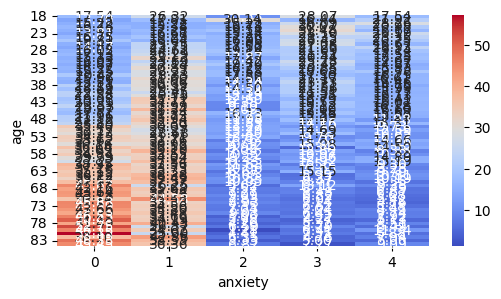

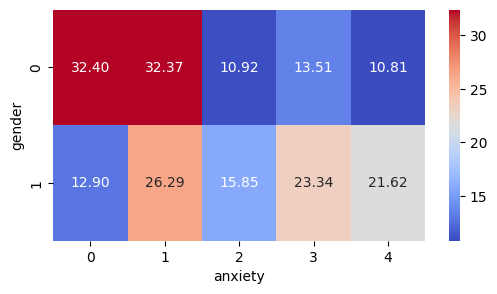

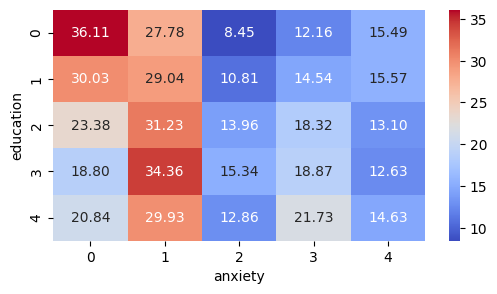

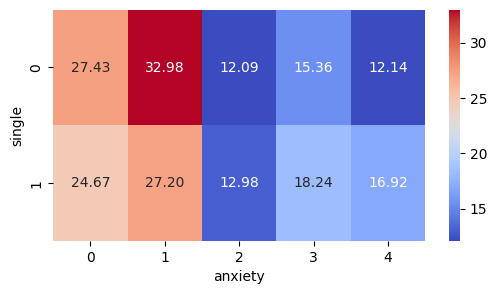

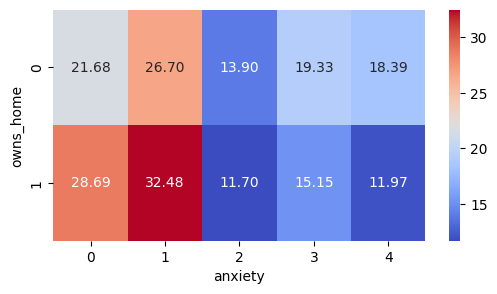

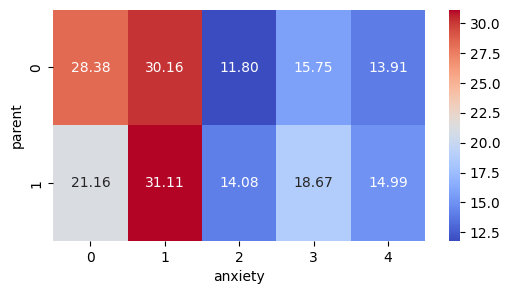

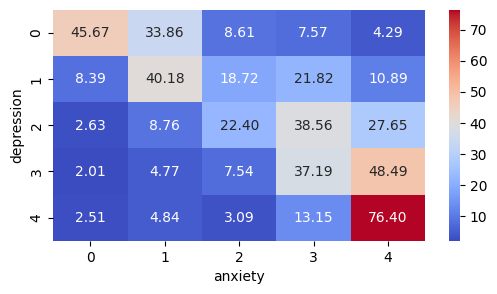

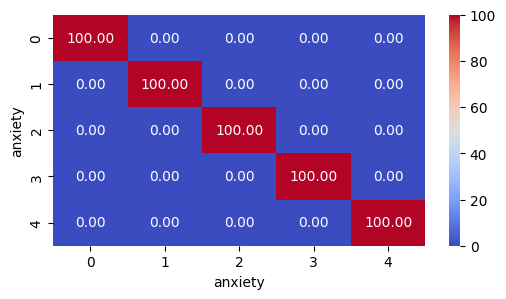

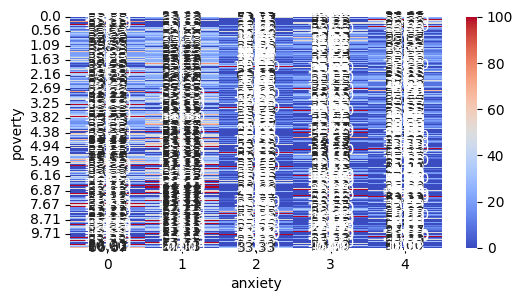

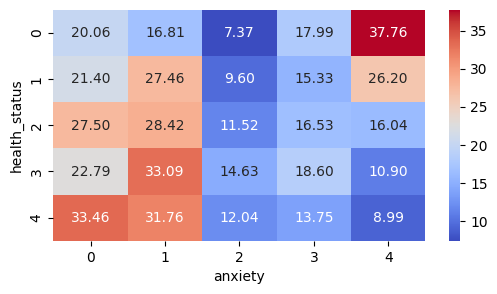

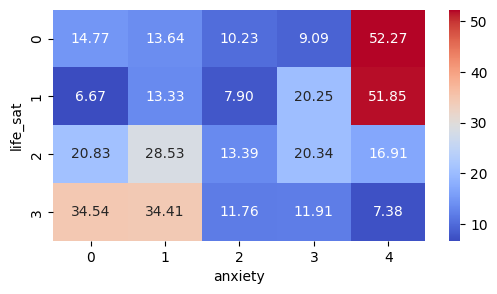

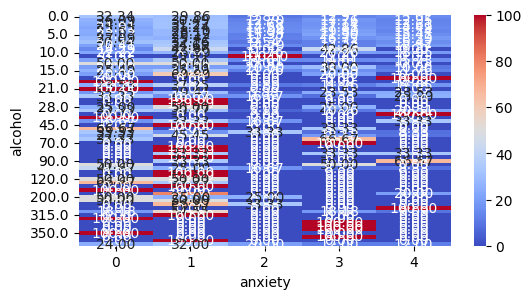

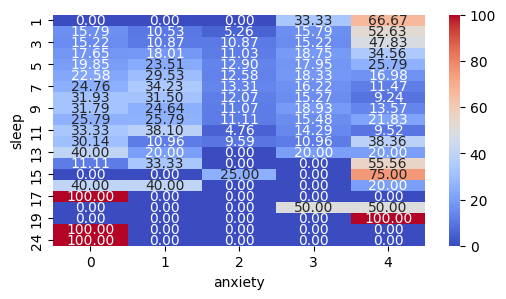

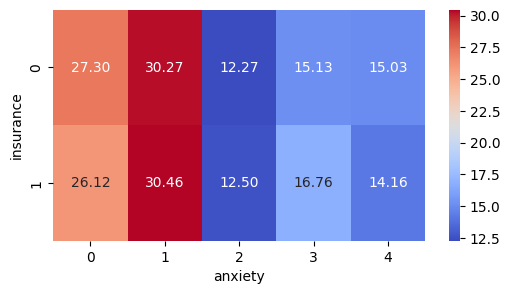

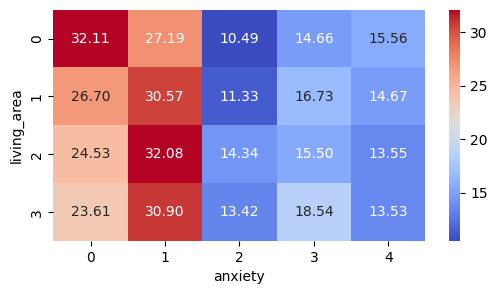

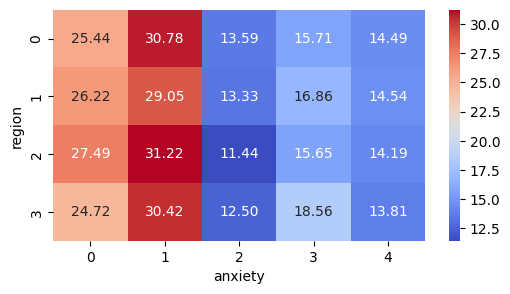

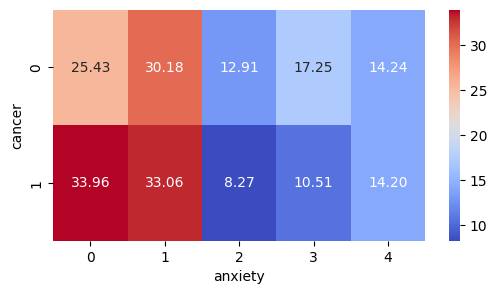

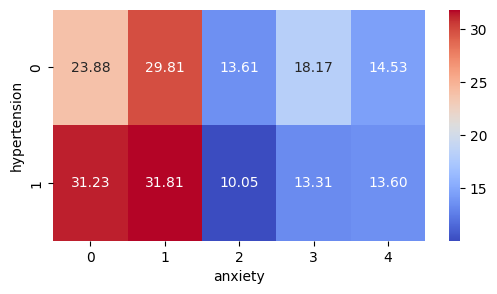

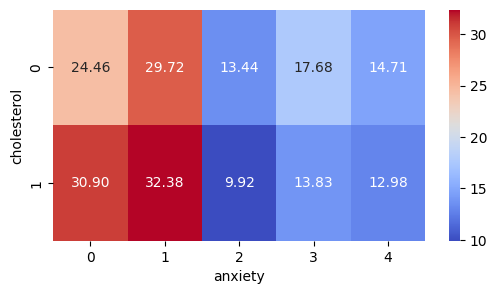

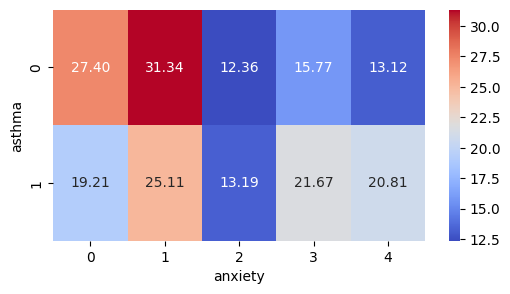

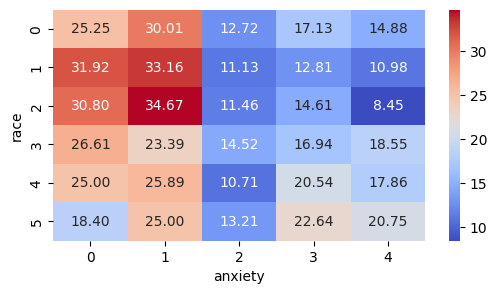

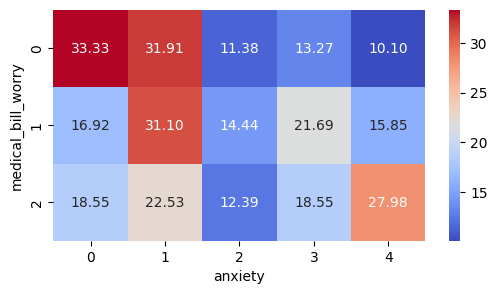

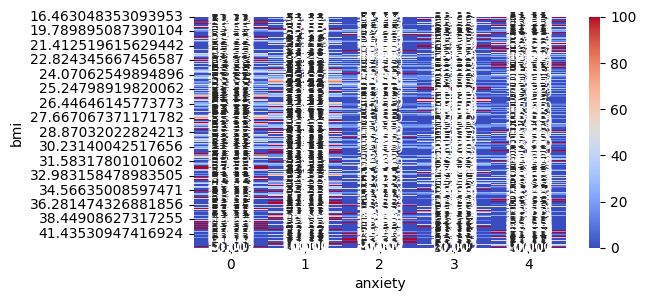

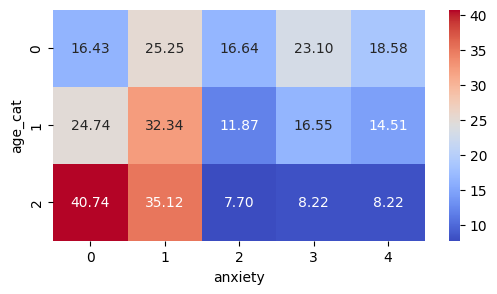

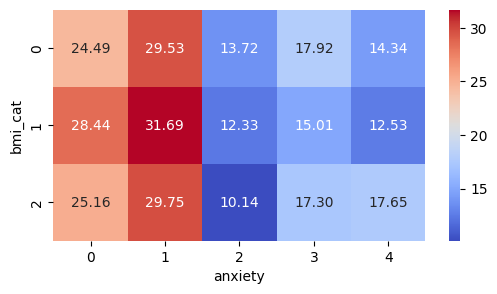

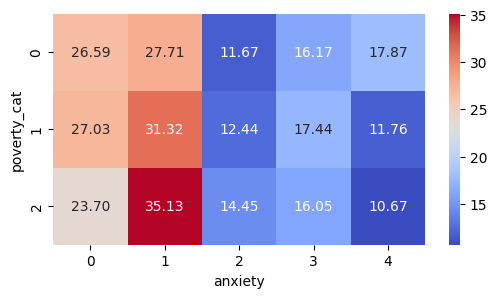

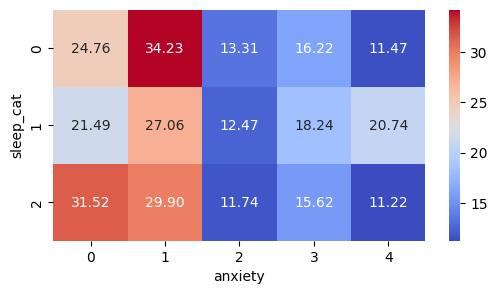

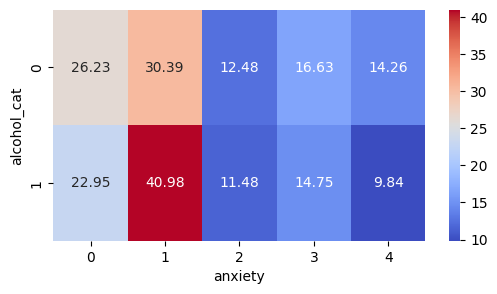

In [59]:
target = "anxiety"

for f in df.columns.values:
    tab = pd.crosstab(df[f], df[target], normalize="index") * 100
    plt.figure(figsize=(6, 3))
    sns.heatmap(tab, fmt='.2f', cmap='coolwarm', annot=True)
    plt.show()

### Chi-square tests